# **Generating Anime Characters with Deep Convolutional GANs (DCGANs) and Keras**
---

## **Usage**:

### **Character Generation**:
1. **Personalized Avatars**: Generate unique anime avatars reflecting player preferences.
2. **NPC Generation**: Create diverse NPCs for richer anime game worlds.
3. **Concept Character Creation**: Rapidly generate character designs for anime inspiration.

### **Anime Generation**
1. **Crowds and Background Characters**: Fill scenes with unique background characters to enhance immersion.
2. **Character Creation Tools**: Suggest unique anime characters based on specified traits.
3. **Dynamic Character Prototypes**: Allow artists to tweak and adjust generated characters.

### **Social Platforms**:
1. **Virtual Avatars for Social Platforms**: Personalize avatars in anime-themed social networks and platforms.
2. **AI-Generated Virtual Influencers**: Create distinct anime influencers for social media engagement.

### **Art Generation**
1. **Fan Art Generation**: Generate new characters based on favorite anime series.
2. **Interactive Visual Novel Characters**: Create dynamic characters responding to player decisions.
---

## **GANs are the Solution**

### **Generative Adversarial Networks (GANs)**
- Generative Adversarial Networks (GANs) are a type of machine learning framework introduced in June 2014 <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>.

- These networks are capable of generating **new data that mimics the statistical features of the training dataset**. GANs have gained popularity for creating new, realistic photographs that appear authentic to human observers.

### **Convolutional Neural Networks (CNNs)**
- Convolutional Neural Networks (CNNs) have become widely used in computer vision applications. By **integrating CNNs with GANs**, we can develop models that generate high-quality images.
- This combined approach is known as Deep Convolutional Generative Adversarial Networks **(DCGANs)**.
---


# **Installing  Necessary Libraries**
- Quietly Installing Packages- (Remove `> /dev/null 2>&1` For Debugging)

In [164]:
!pip install pandas==2.2.2 numpy==1.26.4 seaborn==0.13.1 matplotlib==3.7.1 scikit-learn==1.5.2 > /dev/null 2>&1
!pip install tqdm > /dev/null 2>&1
!pip3 install --upgrade tensorflow > /dev/null 2>&1

In [165]:
import os
import time
import warnings
import numpy as np
import imghdr

import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU

from IPython import display
from pathlib import Path
from tqdm import tqdm




In [166]:
warnings.simplefilter('ignore')
print(f"tensorflow version: {tf.__version__}")
%matplotlib inline

tensorflow version: 2.17.0


In [167]:
def plot_dist(real_data, generated_data, discriminator=None, density=True, RealDataName="Real Data", GenerateDataName="Generated Data"):
    # Plot histogram of real data
    plt.hist(real_data.numpy(), bins=100, density=density, color='green', alpha=0.75, label=RealDataName)

    # Plot histogram of generated data
    plt.hist(generated_data.numpy(), bins=100, density=density, color='red', alpha=0.75, label=GenerateDataName)

    # If a discriminator is provided, plot its decision boundary
    if discriminator:
        # Find the range of values for plotting the discriminator
        data_max = max(real_data.numpy().max(), generated_data.numpy().max())
        data_min = min(real_data.numpy().min(), generated_data.numpy().min())

        # Generate values to plot the discriminator's predictions
        x_values = np.linspace(data_min, data_max, 1000).reshape(-1, 1)

        # Plot the discriminator's output using the sigmoid function
        plt.plot(x_values, tf.math.sigmoid(discriminator(x_values, training=False)).numpy(), label='Discriminator', color='black')

        # Plot the 0.5 decision threshold
        plt.plot(x_values, 0.5 * np.ones(x_values.shape), label='Threshold = 0.5', color='blue')

        # Add a label for the x-axis
        plt.xlabel('Value')

    plt.legend()
    plt.show()



def plot_arr(X, title=""):
    # Set the size of the entire figure (width, height)
    plt.rcParams['figure.figsize'] = (20, 20)

    # Loop through the first 5 arrays in X
    for i, x in enumerate(X[:5]):
        # Convert tensor to a numpy array for easier manipulation
        x = x.numpy()

        # Get the maximum and minimum values from the array
        max_value = x.max()
        min_value = x.min()

        # Normalize the values to be in the range [0, 255] for better image display
        x_normalized = np.uint8(255 * (x - min_value) / (max_value - min_value))

        # Create a subplot for each array
        plt.subplot(1, 5, i + 1)
        plt.imshow(x_normalized)  # Display the image
        plt.axis("off")  # Hide the axes

    plt.show()

---
## **Applications**
* Generate Photographs of Human Faces
* Generate Realistic Photographs
* Generate Cartoon Characters
* Image-to-Image Translation
* Text-to-Image Translation
* Face Frontal View Generation
* Generate New Human Poses
* Face Aging
* Photo Blending
* Super Resolution
* Photo Inpainting
* Clothing Translation
* Video Prediction

# Imagine a Game of **Cakes** Between a Baker and a Food Critic

Let’s use the idea of making **cakes**! In our world, we have two characters:

- **The Baker (Generator – G):** The one who makes cakes but starts off without knowing much about baking.
- **The Food Critic (Discriminator – D):** The expert who has tasted lots of real cakes and can judge if a cake is delicious and real or just a fake, bad cake.

## **The Goal**
The goal is for the **Baker (G)** to make a cake that is **so good** that the **Food Critic (D)** can’t tell whether it was made by a beginner or a master baker!

---

## **How the Game Works**

### Step 1: The Baker Makes the First Cake
At the beginning of the game, the **Baker** doesn't know how to bake a good cake at all. They take a bunch of random ingredients and throw them together into a messy, weird-looking cake.

- **Baker’s cake = Fake cake** (It looks bad and probably tastes bad).
- **Food Critic** looks at the cake, takes one bite, and says, "This is a terrible cake! Definitely fake!" and easily recognizes it as not a real, delicious cake.

---

### Step 2: The Food Critic Helps the Baker Improve
The **Food Critic (D)** is like a teacher in a way. When they say the cake is bad, the **Baker (G)** gets feedback and learns from it. The **Baker** now knows what was wrong with the cake (too salty, too weird-looking) and tries to make a better one next time.

- The **Baker** mixes the ingredients differently and bakes another cake.
- The **Food Critic** checks again. The new cake might still be bad, but maybe it's **slightly better** than the first one. The **Food Critic** still says, "Nope, this is not a real cake!"

---

### Step 3: The Game Repeats, Over and Over
Each time the **Baker (G)** makes a cake, they try to make it **look and taste more like a real, yummy cake**. They want to trick the **Food Critic** into thinking it's a good cake.

But the **Food Critic (D)** is also **getting better** at their job! They have eaten hundreds of cakes before, so they learn how to **spot even small mistakes** and tell which cakes are real and which are fake.

---

### Step 4: Baker Starts to Get Really Good
After many rounds of trying and learning from the **Food Critic’s** feedback, the **Baker** starts to get the hang of it. Maybe now the cake looks fluffy, has the right colors, and smells delicious! The **Food Critic** starts getting confused.

- Sometimes, the **Food Critic** might look at a cake and **almost** think it’s real but still finds a tiny problem and says, "Wait, this frosting doesn't look perfect. Fake!"

---

### Step 5: Finally, the Baker Wins!
After many attempts, the **Baker** finally makes a cake that is so good, the **Food Critic** can’t tell if it’s fake anymore! The cake **looks, smells, and tastes just like a real cake**.

- The **Food Critic** is **fooled**!
- The **Baker** wins because they have learned to make a cake that looks just as real as a cake from a professional bakery!

---

## **How This Relates to a GAN**:
In a **GAN (Generative Adversarial Network)**, the two parts are always **competing** with each other and learning at the same time:

1. **Baker = Generator (G):** The generator starts with random noise (like a bunch of random ingredients) and learns how to create something that looks like the real data (real cakes).
   
2. **Food Critic = Discriminator (D):** The discriminator tries to tell if what it’s looking at is real or fake (real cakes vs. fake cakes). At first, it can easily spot fake ones, but as the **Generator** gets better, it becomes harder for the **Discriminator** to tell.

- The **Baker (Generator)** gets better at making realistic things.
- The **Food Critic (Discriminator)** gets better at spotting fakes.
  
They both improve by **competing** with each other, and in the end, the **Generator** becomes so good at creating realistic-looking cakes (or images, in the case of a GAN), that even an expert can’t tell they’re fake.

---

## **Let’s Go Deeper into the GAN Process**

Now that you understand the basic idea of the game, let’s break down how a GAN works step by step:

1. **The Generator (G):**
   - Think of this as the **Baker** who starts with random noise (like a bunch of random ingredients) and tries to create something meaningful, like an image or a cake. The Generator creates **fake examples**.
   
2. **The Discriminator (D):**
   - This is like the **Food Critic** who looks at two things:
     - **Real Data** (real cakes or real images)
     - **Fake Data** created by the **Generator**.
   - The **Discriminator** tries to tell which one is real and which one is fake. The better it gets, the harder it becomes for the Generator to fool it.

3. **The Feedback Loop:**
   - Every time the **Discriminator** spots a fake, the **Generator** learns from it and tries again.
   - The **Generator** improves bit by bit, making its creations more realistic.
   - The **Discriminator** also improves and gets better at identifying the fakes.

4. **Training Process:**
   - This process of the **Generator** creating fake data and the **Discriminator** judging it happens **thousands** of times.
   - Over time, the **Generator** creates fake images or data that are so convincing, they **look just like the real thing**.

---

## **Summary in Fun Terms**:
- **Baker (Generator):** Learns to make realistic cakes (images).
- **Food Critic (Discriminator):** Tries to tell if the cakes are real or fake.
- **Feedback Loop:** Each time the Baker makes a better cake, and the Critic gets better at judging it.
- **End Result:** The Baker becomes so good that even the Food Critic is fooled into thinking the fake cakes are real!

---

GANs are like a **friendly competition** between two players who keep learning from each other until one of them (the Generator) becomes **amazingly skilled** at creating things that look like real-world objects!

---

## **Toy Data**

#### **Sampling Data from a Normal Distribution**

- We have some data, which we'll call **x**, and we know that it follows a normal distribution. This distribution is described by two important properties:

- **Mean**: The center of the distribution, which is 10.
Standard Deviation: The spread of the data around the mean, which is 1.

- So, the data x is normally distributed with:
- **Mean** = 10
- **Standard deviation** = 1
- `x ~ N(10, 1)`

In [168]:
mean = [10]
cov = [[1]]

Z = tf.random.normal((5000,1), mean=0, stddev=2)
X = tf.random.normal((5000,1), mean=10, stddev=1)

'''
  1. mean = [10]
  - This defines the mean of the data distribution.
  - It's set to 10, meaning the center of our data will be around 10.

  2. cov = [[1]]
  - This is meant to define the covariance or variance of the data, but in this case,
  - it's not used because you're generating data directly using TensorFlow's tf.random.normal function.
  - Covariance indicates how much variables change together, and since we only have one variable here (1-dimensional data),
  - it's just a single value (1), which is the variance.

  3. X = tf.random.normal((5000,1), mean=10, stddev=1.0)
  - This function from TensorFlow generates 5000 random samples from a normal distribution.
  - Each sample is one-dimensional (shape: 5000x1).
  - So, this line creates a sample of 5000 points drawn from a normal distribution with a mean of 10 and a standard deviation of 1.

  4. print("mean:", np.mean(X))
  - This prints the mean of the generated data X.
  - Since we drew samples from a distribution with a mean of 10,
  - We expect the printed value to be very close to 10 (it might not be exactly 10 due to random sampling).

  5. print("standard deviation:", np.std(X))
  - This prints the standard deviation of the generated data X.
  - Since the data was generated with a standard deviation of 1,
  - we expect the printed value to be close to 1.
'''


print("Mean:", np.mean(X))
print("Mean:", np.mean(Z))
print("Standard Deviation:", np.std(X))
print("Standard Deviation:", np.std(Z))

Mean: 9.99456
Mean: -0.008518568
Standard Deviation: 1.0068126
Standard Deviation: 2.002143


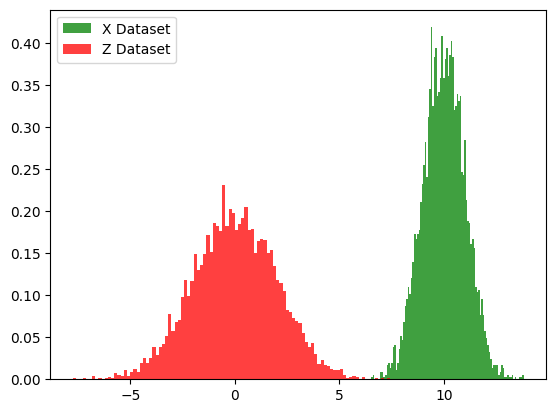

In [169]:
plot_dist(real_data=X, generated_data=Z, discriminator=None, density=True, RealDataName='X Dataset', GenerateDataName='Z Dataset')

In [170]:
Xhat= (Z + 10)

- We made a new set of data by adding 10 to each value in the original data.
- This new data is similar to the original and is spread out in a way that can be described as a **bell-shaped curve**,
- with an average value of 10 and a certain amount of variation.

Mean: 9.991481
Standard Deviation: 2.002143


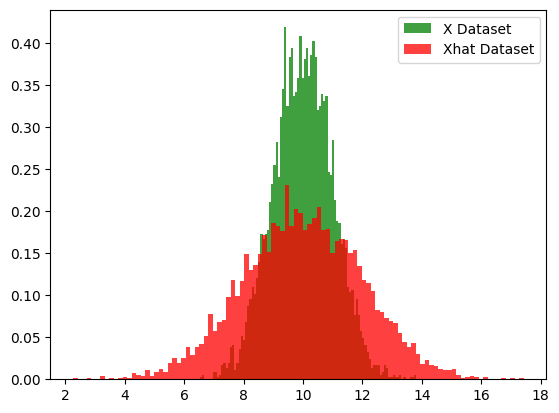

In [171]:
print("Mean:", np.mean(Xhat))
print("Standard Deviation:", np.std(Xhat))

plot_dist(real_data=X, generated_data=Xhat, discriminator=None, density=True, RealDataName='X Dataset', GenerateDataName='Xhat Dataset')

## **The Generator**:

- In a **Generative Adversarial Network (GAN)****, there are two main components: the Generator and the Discriminator.

- The **Generator** is a type of neural network (**NNs**), and it is designed to learn and mimic any kind of data distribution. This capability is based on a principle that suggests neural networks can approximate any function.

- Our main objective for the Generator is to **take random input samples and transform them into data that resembles real samples**. In this case, we want the output to be similar to the data we want to generate.

- To create a simple Generator, we can use a structure where the output is based on the input samples, combined with **some learned weights and biases**. We will use Keras, a popular machine learning library, to build this Generator model.

- The following function will create a **Generator using Keras's Sequential model**, which allows us to stack layers to build our neural network.


In [172]:
def MakeGeneratorModel():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

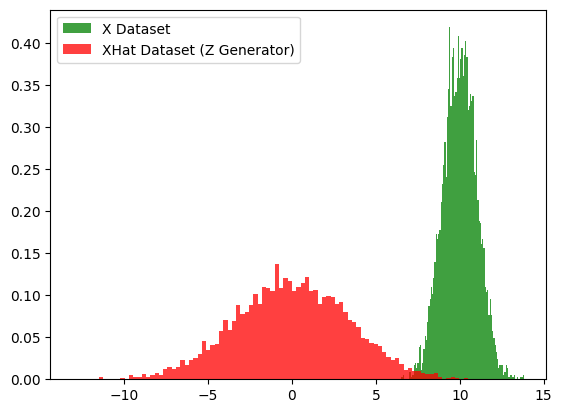

In [173]:
generator = MakeGeneratorModel()

Xhat = generator(Z, training=False)
plot_dist(real_data=X, generated_data=Xhat, RealDataName='X Dataset', GenerateDataName='XHat Dataset (Z Generator)')

## **The Discriminator**

- The discriminator D(x) is a neural network that learns to distinguish between actual and generated samples.

- The simplest Discriminator is a simple logistic regression function.

- Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function,

- which is the convention in Keras.

In [174]:
def MakeDiscriminatorModel():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=MakeDiscriminatorModel()

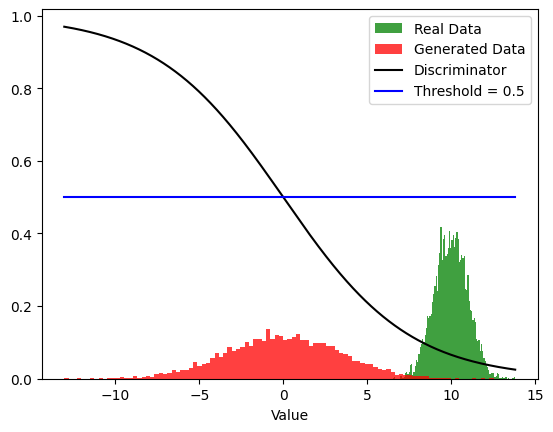

In [175]:
plot_dist(real_data=X, generated_data=Xhat, discriminator=discriminator)

- The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis.

- We also include the threshold.
- **If the output of the logistic function is less than 0.5, the sample is classified as generated data**;
- conversely, **if the output is greater than 0.5, the sample will be classified as data that came from the real distribution**.

#### **Sigmoid**
- Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

- For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:

In [176]:
real_predictions = tf.math.sigmoid(discriminator(X, training=False))
count_real_above_threshold = np.sum(real_predictions > 0.5)
print(count_real_above_threshold)

0


#### **Interpretation**
- For the generated data, only a part of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.

In [177]:
generated_predictions = discriminator(Xhat)
count_above_threshold = np.sum(generated_predictions > 0.5)
print(count_above_threshold)

1444


- We can also use the following to **find the average value** of the **sigmoid function** for all the samples.

In [178]:
def calculate_discriminator_accuracy(real_data, generated_data):
    # Get the discriminator's prediction for real data
    real_predictions = tf.math.sigmoid(discriminator(real_data, training=False))
    real_accuracy = np.mean(real_predictions)

    # Get the discriminator's prediction for generated data
    generated_predictions = tf.math.sigmoid(discriminator(generated_data, training=False))
    generated_accuracy = np.mean(generated_predictions)

    # Calculate the average accuracy between real and generated data
    overall_accuracy = (real_accuracy + generated_accuracy) / 2

    return overall_accuracy

In [179]:
calculate_discriminator_accuracy(real_data=X, generated_data=Xhat)

0.28420490026474


### **Notes**:

We'll be utilizing a Differential-Critic GAN as explained in this [paper](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/2107.06700.pdf).

----------

### **The Loss Function in GANs (Optional)**

GANs (Generative Adversarial Networks) convert an unsupervised learning problem into a supervised one. Instead of formulating the problem as a two-player minimax game (as described in [this paper](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf)), we can approach the problem by maximizing the log-likelihood of the logistic function. This is analogous to minimizing the cross-entropy loss, incorporating both the generator and the discriminator.

### **Discriminator**

To train GANs, we start by maximizing the likelihood for the discriminator using the standard dataset $\mathcal{D}=\{{(x_1, y_1), ..., (x_N, y_N)}\}$:

$$V(D)=\sum_{n=1}^N \left( y_n \ln(D(\mathbf{x}_n))+(1-y_n) \ln(1-D(\mathbf{x}_n))\right)$$


- Where $y=1$ for samples from the true distribution and $y=0$ for samples from the generator. The goal is to maximize this term with respect to $D$:

- Here,$y = 1$ represents samples from the true data distribution, while $y = $0y represents samples from the generator.

- The objective is to maximize this term with respect to the discriminator:

$$max_{D}(V(D))$$

----------
#### Explanation of Key Concepts:

-   **Maximizing Log-Likelihood**: The goal here is to increase the probability of the discriminator correctly identifying real samples as real and generated samples as fake.
-   **Cross-Entropy Loss**: By maximizing the log-likelihood, we effectively minimize the cross-entropy loss, which is the standard approach in classification problems.
---

To also incorporate the generated samples, we augment the right side of the equation with the generated $k$th sample $\hat{\mathbf{x}}_k$. As they are not part of the dataset $k \notin \mathcal{D} $, we have to include a second summation **where $y=0$. Finally, combining the cases of $y=1$ and $y=0$, we get**:

$$V(D)=\sum_{ n	\in \mathcal{D}}  \ln(D(\mathbf{x}_n))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(\hat{\mathbf{x}}_k) ) $$

---
### **Generator**
For the generator we simply replace $\hat{\mathbf{x}}_k$ with the $G(\mathbf{z}_k)$ .


$$V(G,D)=\sum_{n	\in \mathcal{D}} \ln(D(\mathbf{x}_n))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}_k))) $$

As this is a density estimation problem, it is common to replace the summation with the expected value like in <a href=https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1406.2661.pdf >[1]</a>. We replace the summations with an expectation where $p(\mathbf{x})$ is the true distribution and $p(\mathbf{z})$ is the distribution of $\mathbf{z}$.


$$V(D,G)=\mathbb{E}_{x\sim p(\mathbf{x})} \ln(D(\mathbf{x})) + \mathbb{E}_{\mathbf{z} \sim p(\mathbf{z})} \ln(1-D(G(\mathbf{z}) )) $$

As we are trying to trick the discriminator, we would like to find a $G$ that minimize the above expression, such as:

$$min_{G} max_{D} V(D,G)$$


## **Training GANs**

Training Generative Adversarial Networks (GANs) is challenging because both the **generator** and **discriminator** must improve simultaneously. Even for simple problems, balancing the training of both networks can be difficult.

#### Image Explanation:
The provided image likely visualizes the GAN architecture, showing how the generator and discriminator interact during training.

---

### **Training the Generator**

When training a GAN, the **generator** creates fake samples in an attempt to fool the **discriminator** (which tries to distinguish between real and fake data).

1. **Initial Issue**:
   The term \( \log(1 − D(G(\mathbf{z}))) \) is problematic during early training stages. Initially, the generator produces poor-quality data, so the discriminator easily detects fake samples. This causes \( D(G(\mathbf{z})) \) to be very close to 0 or 1, making the log term small and providing little gradient for improving the generator.

2. **Solution**:
   To overcome this, we instead maximize \( \log(D(G(\mathbf{z}_k))) \). This approach helps the generator improve faster, especially in the early training steps, because the learning signal is stronger when focusing on increasing the discriminator’s output.

---

### Training Process

- **Discriminator's Role**:
  During training, the output of the generator is passed to the discriminator, which predicts whether the data is real or fake. However, while the generator’s output is evaluated, the generator itself is not updated during the discriminator's optimization step.
  
- **Setting `training=False`**:
  In Keras and similar frameworks, we set `training=False` during the discriminator's evaluation to ensure that the generator is not updated when the discriminator is being trained.

---

### Optimization Strategy

Instead of maximizing \( \log(D(G(\mathbf{z}_k))) \), we take the **negative** of the expression and minimize it. This is mathematically equivalent but computationally easier.

- **Keras Implementation**:
  In Keras, this can be achieved using **cross-entropy loss**, where the target values for the generator are set to 1. This means the generator is learning to produce data that the discriminator classifies as real.

- **Generator's Loss**:
  The expression to minimize for the generator is: $\sum_{k \notin \mathcal{D}} \log(1 - D(G(\mathbf{z}_k)))$

  This expression reflects the generator’s goal to reduce the difference between generated data and real data, as judged by the discriminator.

---

### Summary

- GAN training is difficult because both the generator and discriminator must improve in tandem.
- Optimizing $
\log(1 − D(G(\mathbf{z})))$ is inefficient early on, so we optimize $\log(D(G(\mathbf{z}_k)))$ instead.
- In Keras, cross-entropy loss is used, where the generator’s targets are set to 1 to trick the discriminator.
- By minimizing this loss, the generator learns to produce more realistic data over time.


In [180]:
# Create a Binary Crossentropy loss function for the generator
binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def compute_generator_loss(fake_outputs):
    """
    Calculate the generator loss using binary crossentropy.

    Args:
        fake_outputs (tensor): The discriminator's output for the generated data.

    Returns:
        tensor: The computed loss value for the generator.
    """
    # The generator aims to produce outputs that the discriminator classifies as real (1s)
    target_labels = tf.ones_like(fake_outputs)

    # Calculate the crossentropy loss
    loss = binary_crossentropy_loss(target_labels, fake_outputs)
    return loss

### **Training Discriminator**

We can also utilize cross-entropy to train the discriminator. To do this, we simply multiply \( V(G,D) \) by a negative number, set (y=0) for the generated values, and \( y=1 \) for the real values. It's important to note that we do not update the generator parameters during this process.

The loss function for the discriminator can be expressed as:


$V(G) = \sum_{n \in \mathcal{D}} \ln(D(\mathbf{x}_n)) + \sum_{k \notin \mathcal{D}} \ln(1 - D(G(\mathbf{z}_k)))$


This equation represents the objective of the discriminator to correctly classify real samples from the dataset \(\mathcal{D}\) and to reject the generated samples from the generator.


In [181]:
# Binary cross-entropy loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def compute_discriminator_loss(real_samples, fake_samples):
    """
    Calculate the loss for the discriminator using binary cross-entropy.

    Args:
        real_samples (tensor): The real data samples.
        fake_samples (tensor): The generated data samples produced by the generator.

    Returns:
        tensor: The computed loss value for the discriminator.
    """
    # Calculate the loss for real samples (should be classified as 1)
    real_loss = cross_entropy(tf.ones_like(real_samples), real_samples)

    # Calculate the loss for fake samples (should be classified as 0)
    fake_loss = cross_entropy(tf.zeros_like(fake_samples), fake_samples)

    # Average the losses
    total_loss = 0.5 * (real_loss + fake_loss)
    return total_loss

- Create **Optimizers** for Generators & Discriminators!

In [182]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)

### Training the Model

In this training process, we will use **batch gradient descent** due to the small size of the dataset. The following steps outline the training iterations:

1. **Generate Real Examples**:
   - For each iteration, we will generate $M$ real examples ${\mathbf{x}_{1}, ...,\mathbf{x}_{M}}$ from the generating distribution $p(mathbf{x})$
   - These real examples represent our actual dataset, similar to what we would use if we had access to real data.

2. **Generate Noise Samples**:
   - Next, we will generate a batch of $M$ noise samples ${\mathbf{z}_{1}, ...,\mathbf{z}_{M}}$ from a noise prior $p(\mathbf{z})$.
   - These noise samples will then be fed into the generator to create synthetic images.

3. **Generate Fake Samples**:
   - The generator will process the noise samples to produce a batch of generated images ${\hat{\mathbf{x}}_{1}, ...,\hat{\mathbf{x}}_{M}}$ \).

4. **Discriminator Evaluation**:
   - We will determine the output of the discriminator for both the real samples ${\mathbf{x}_{1}, ...,\mathbf{x}_{M}}$ and the generated samples ${\hat{\mathbf{x}}_{1}, ...,\hat{\mathbf{x}}_{M}}$.

5. **Loss Calculation**:
   - The loss will be calculated for both the discriminator and generator based on their outputs.

6. **Update Models**:
   - Finally, we will update the parameters of both the discriminator and generator using their respective stochastic gradients.

This iterative process helps the generator improve its ability to create realistic images while training the discriminator to better distinguish between real and fake samples.

---
The convergence of **GAN training** is a subject in itself. But let's explore a method that works for this simple dataset. Intuitively, we know that if our generated data is identical to our actual data, the probability of correctly classifying is random. Therefore if the generated and actual data are of equal proportion, $D(\mathbf{x}_n)=0.5$ and $D(\hat{\mathbf{x}}_n)=0.5$.  

We only display iterations where the average discriminator output gets closer to 50% for both the generated data and actual data.


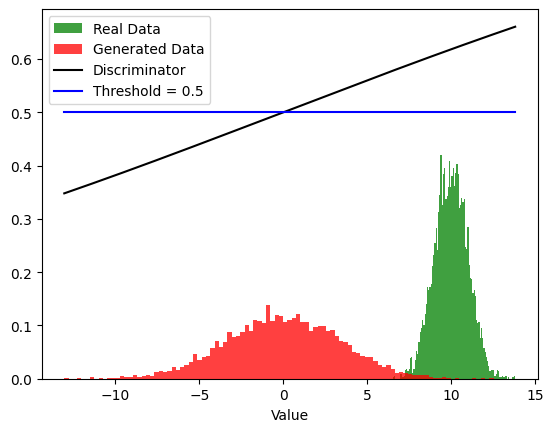

Epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]

0.7105527520179749


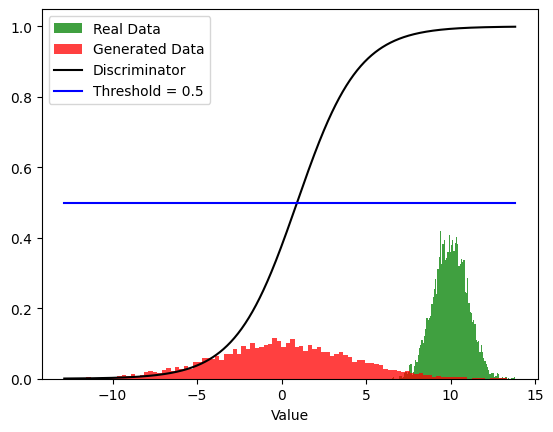

  5%|▌         | 1/20 [00:04<01:21,  4.27s/it]

Epoch 0
0.6838760375976562


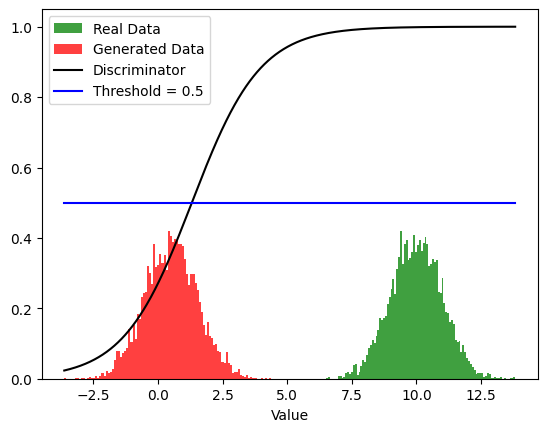

 15%|█▌        | 3/20 [00:06<00:26,  1.58s/it]

Epoch 1
0.5875857472419739


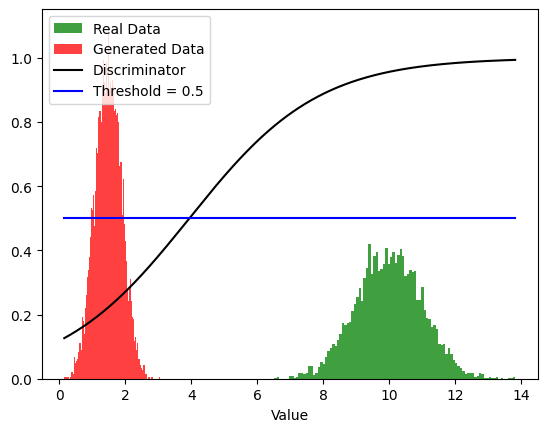

 20%|██        | 4/20 [00:07<00:26,  1.67s/it]

Epoch 3
0.4418048560619354


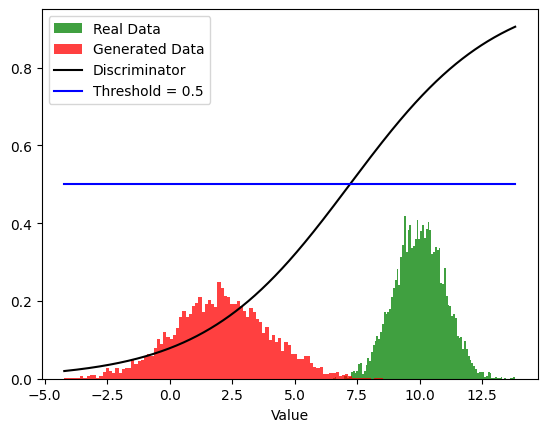

 25%|██▌       | 5/20 [00:09<00:25,  1.67s/it]

Epoch 4


 35%|███▌      | 7/20 [00:10<00:11,  1.12it/s]

0.5123751759529114


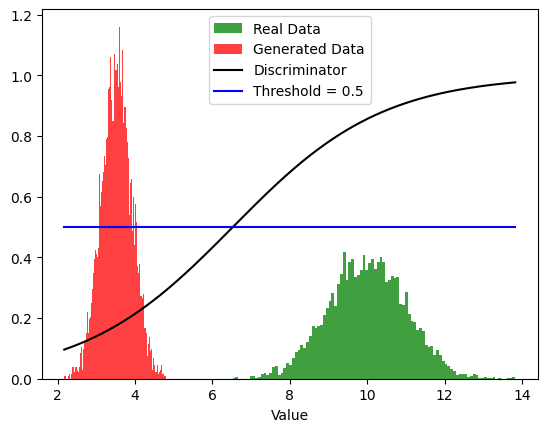

 40%|████      | 8/20 [00:13<00:18,  1.53s/it]

Epoch 7


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


In [183]:
# Parameters for training
epochs = 20                  # Number of epochs to train the model
BATCH_SIZE = 5000            # Number of samples in each batch
noise_dim = 1                # Dimensionality of the noise input for the generator
epsilon = 100                # Threshold for monitoring performance

# Initialize the discriminator and generator
tf.random.set_seed(0)        # Set a random seed for reproducibility
discriminator = MakeDiscriminatorModel()  # Create the discriminator model
generator = MakeGeneratorModel()          # Create the generator model

# Enable eager execution for TensorFlow functions
tf.config.run_functions_eagerly(True)

# Lists to store loss values for each epoch
gen_loss_epoch = []
disc_loss_epoch = []

# Plot the initial distribution of real vs. generated data
plot_dist(real_data=X, generated_data=Xhat, discriminator=discriminator)
print("Epoch", 0)

# Training loop for the specified number of epochs
for epoch in tqdm(range(epochs)):
    # Generate true data samples from a normal distribution
    x = tf.random.normal((BATCH_SIZE, 1), mean=10, stddev=1.0)
    # Generate random noise samples
    z = tf.random.normal([BATCH_SIZE, noise_dim], mean=0, stddev=10)  # Increased stddev for better results
    # Use gradient tapes to record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate samples using the generator
        xhat = generator(z, training=True)
        # Get discriminator outputs for real and generated samples
        real_output = discriminator(x, training=True)
        fake_output = discriminator(xhat, training=True)
        # Calculate the losses for the generator and discriminator
        gen_loss = compute_generator_loss(fake_output)       # Loss for the generator
        disc_loss = compute_discriminator_loss(real_output, fake_output)  # Loss for the discriminator

    # Compute gradients for the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply the computed gradients to update the model weights
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Save and display the generator and discriminator if performance improves
    current_accuracy = calculate_discriminator_accuracy(x, xhat)
    if abs(0.5 - current_accuracy) < epsilon:
        epsilon = abs(0.5 - current_accuracy)  # Update epsilon to the new threshold
        generator.save('./generator.keras')  # Save the generator model in Keras format
        discriminator.save('./discriminator.keras')  # Save the discriminator model

        # Print accuracy and plot the distribution of real vs. generated data
        print(current_accuracy)
        plot_dist(real_data=X, generated_data=xhat, discriminator=discriminator)
        print("Epoch", epoch)


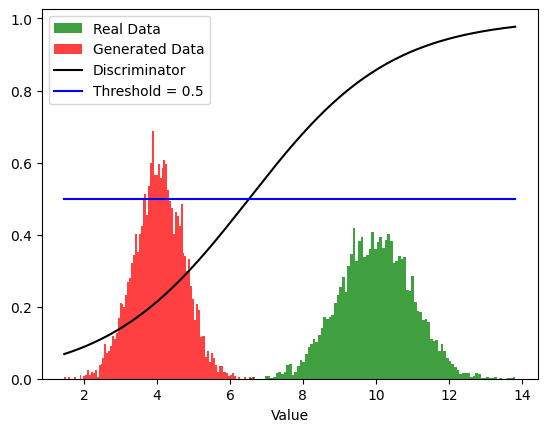

In [184]:
generator= MakeGeneratorModel()
generator= models.load_model('./generator.keras')
xhat=generator(z)
discriminator=models.load_model('./discriminator.keras')
plot_dist(real_data=X,generated_data=xhat,discriminator=discriminator )

# **Deep Convolutional Generative Adversarial Networks (DCGANs)**

## **Background**

In this scenario, you are part of an online anime video game company that aims to generate unique anime avatars for each of its millions of players. Given the scale of the task, employing **Deep Convolutional Generative Adversarial Networks (DCGANs)** is an effective approach to create these diverse characters. DCGANs leverage deep learning techniques to generate high-quality images, making them particularly suitable for the vibrant and stylized nature of anime art.

### Proposed Approaches

To ensure the successful implementation of DCGANs for avatar generation, the following strategies are recommended:

- **Replace Pooling Layers**: Utilize **strided convolutions** in the discriminator and **fractional-strided convolutions** in the generator. This modification helps maintain spatial hierarchies and allows for better feature extraction without losing important information in the images.

- **Implement Batch Normalization**: Introduce **batch normalization** in both the generator and the discriminator. This technique normalizes the inputs to each layer, stabilizing the learning process and enabling the use of higher learning rates, which can speed up convergence.

- **Eliminate Fully Connected Layers**: **Remove fully connected hidden layers** for deeper architectures. This change not only reduces the number of parameters (leading to faster training) but also enhances the model's ability to learn spatial hierarchies directly from the convolutional layers.

- **Choose Appropriate Activations**:
  - For the generator, use **ReLU** (Rectified Linear Unit) activation functions in all layers except for the output layer, which should employ **Tanh**. The Tanh function helps in producing outputs in the range of [-1, 1], which is often more suitable for generating pixel values.
  - In the discriminator, use **Leaky ReLU** for all layers except the output layer, which should use **Sigmoid**. Leaky ReLU addresses the issue of dying ReLU units by allowing a small, non-zero gradient when the unit is inactive, which helps improve the model's performance.

- **Utilize the Adam Optimizer**: Opt for the **Adam optimizer**, known for its efficiency and ability to handle sparse gradients. Adam combines the advantages of two other extensions of stochastic gradient descent, making it particularly effective for training deep neural networks.

### Conclusion

Implementing these strategies will enhance the stability and performance of your DCGANs, allowing you to effectively generate high-quality and diverse anime avatars for your game's vast player base. By leveraging the unique capabilities of DCGANs, you can create a more engaging and personalized experience for players, further enriching the overall gaming experience.


---

### Loading the Dataset

We will mainly work with the Anime Face dataset from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01). The original dataset has 63,632 "high-quality" anime faces, but to make the models train faster in this lab, we randomly sampled 20,000 images and prepared a dataset called `cartoon_20000`.

Let's download the smaller dataset using the Skills Network library's `prepare` function:

---

In [201]:
!rm -rf anime_dataset
!kaggle datasets download -d splcher/animefacedataset > /dev/null 2>&1

In [202]:
!unzip -q /content/animefacedataset.zip
!mv images anime_dataset
!rm -rf animefacedataset.zip

In [204]:
img_height, img_width, batch_size = 64, 64, 128

In [205]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='anime_dataset',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)

Found 63565 files.


- The train_ds we defined is a `tf.data.Dataset` that yields batches of images with `image_size = (64, 64)` from the directory specified or subdirectories (if any).

---
## **Normalizing Image Pixel Values**

In our image preprocessing pipeline, we apply a **Lambda function** to the training dataset (`train_ds`) to normalize the pixel values of all input images. The normalization process transforms the pixel values from the original range of \([0, 255]\) to a new range of \([-1, 1]\).

### **Why Normalize?**

Normalization is crucial in machine learning and deep learning for several reasons:

- **Improved Convergence**: It helps in faster convergence during training by allowing the model to learn more efficiently.
- **Uniform Scale**: By rescaling the pixel values, we ensure that all features contribute equally to the loss calculation.
- **Reduced Sensitivity**: Normalized data reduces sensitivity to the scale of the input features, leading to more stable training.

### **How It Works**

The normalization can be achieved with the following formula:

$\text{normalized value} = \frac{\text{original value}}{127.5} - 1$

This formula rescales the pixel values as follows:

- For a pixel value of **0**:
  $\text{normalized value} = \frac{0}{127.5} - 1 = -1$
- For a pixel value of **255**:
  $\text{normalized value} = \frac{255}{127.5} - 1 = 1$

By applying this Lambda function across all images in `train_ds`, we ensure that the pixel values are normalized properly for further processing in our machine learning model.